# Is it a bird? Creating a model from your own data

In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket, warnings

try: 
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(("1.1.1.1", 53))

except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [6]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities

import os

iskaggle = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "")

if iskaggle: 
    !pip install -Uqq fastai "duckduckgo_search>6.2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 69.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.5 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12

## Step 1: Download images of birds and non-birds

In [12]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *
import time, json

def search_images(keywords, max_images=200): 
    return L(DDGS().images(keywords, max_results=max_images)).itemgot("image")

In [15]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).

urls = search_images("bird photos", max_images=1)
urls[0]

'https://images.pexels.com/photos/97533/pexels-photo-97533.jpeg?cs=srgb&dl=animal-avian-bird-97533.jpg&fm=jpg'

In [16]:
urls

(#1) ['https://images.pexels.com/photos/97533/pexels-photo-97533.jpeg?cs=srgb&dl=animal-avian-bird-97533.jpg&fm=jpg']

In [17]:
type(urls)

fastcore.foundation.L

In [18]:
from fastdownload import download_url

dest = "bird.jpg"
download_url(urls[0], dest, show_progress=False)

Path('bird.jpg')

In [21]:
download_url(urls[0], dest, show_progress=True)

Path('bird.jpg')

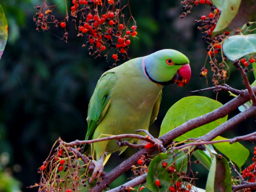

In [22]:
from fastai.vision.all import *

im = Image.open(dest)
im.to_thumb(256,256)

In [27]:
!ls
!pwd

bird.jpg
/kaggle/working


In [26]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/bird.jpg


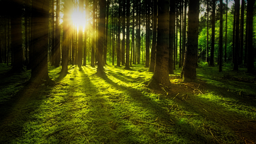

In [28]:
download_url(search_images("forest photos", max_images=1)[0], "forest.jpg", show_progress=True)
Image.open("forest.jpg").to_thumb(256,256)

In [30]:
searches = "forest", "bird"
path = Path("bird_or_not")

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f" {o} photo"))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

In [31]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

13

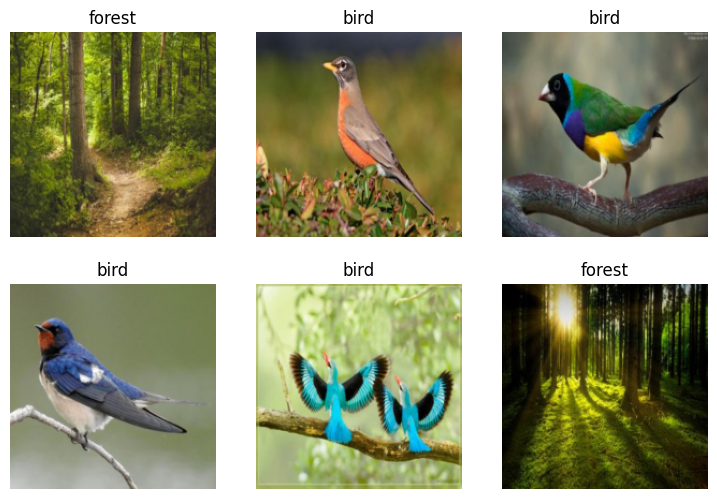

In [32]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct=0.2, seed=42), 
    get_y = parent_label, 
    item_tfms = [Resize(192, method="squish")]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [34]:
%%time
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.527740,0.039541,0.013889,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.045901,0.014421,0.013889,00:54
1,0.026799,0.010374,0.000000,00:54
2,0.021723,0.001184,0.000000,00:54


CPU times: user 5min 51s, sys: 36.7 s, total: 6min 28s
Wall time: 3min 22s


The main difference between CPU time and wall time lies in what they measure. CPU time focuses on the active computation time of the CPU, excluding any waiting periods. In contrast, wall time considers the entire duration of a process or operation, including both active execution and waiting times. [[1]](https://www.yourkit.com/docs/dotnet-profiler/latest/help/wall-and-cpu-times-when-profiling-net-applications.jsp#:~:text=The%20main%20difference%20between%20CPU,active%20execution%20and%20waiting%20times.)

Multicore processors, which incorporate multiple processing units, can run several threads at once to use more CPU time than real (wall) time. [[2]](https://www.techtarget.com/whatis/definition/wall-time-real-world-time-or-wall-clock-time#:~:text=Multicore%20processors%2C%20which%20incorporate%20multiple,than%20real%20(wall)%20time.)

## Step 3: Use our model (and build your own!)

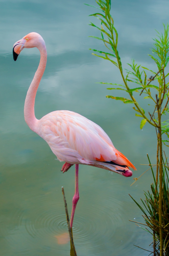

In [53]:
urls = search_images("pink flamingo photos", max_images=1)
dest = "test1.jpg"
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

In [67]:
is_bird,idx,probs = learn.predict(PILImage.create("test1.jpg")) 
print(f"This is a: {is_bird}. ")
print(f"Probability it's a bird: {probs[idx]:.4f}")

This is a: bird. 
Probability it's a bird: 1.0000


In [54]:
learn.predict(PILImage.create("test1.jpg")) 

('bird', tensor(0), tensor([1.0000e+00, 3.6881e-06]))

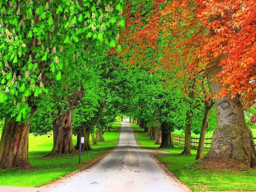

In [55]:
urls = search_images("trees photos", max_images=1)
dest = "test2.jpg"
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

In [68]:
category,idx,probs = learn.predict(PILImage.create("test2.jpg")) 
print(f"This is a: {category}. ")
print(f"Probability it's a {category}: {probs[idx]:.4f}")

This is a: forest. 
Probability it's a forest: 1.0000


In [57]:
learn.predict(PILImage.create("test2.jpg")) 

('forest', tensor(1), tensor([4.0384e-07, 1.0000e+00]))

[Understanding the return values of Learner.predict](https://forums.fast.ai/t/understanding-the-return-values-of-learner-predict/103470)

In [66]:
class_labels = learn.dls.vocab
print(class_labels)

['bird', 'forest']


In [69]:
learn.dls